In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [8]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [9]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [10]:
# # Review unperturbed elements
# elts_ast

In [11]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [12]:
# Inputs to perturb elements: small
sigma_a = 0.01
sigma_e = 0.0025
sigma_inc_deg = 0.05
sigma_f_deg = 0.25
sigma_Omega_deg = 0.25
sigma_omega_deg = 0.25
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.025900,5342.395278,0.999665,0.550588,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.033026,6812.476092,0.999455,0.895261,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003801,0.012795,-0.977103,0.212383,2.702320,0.007222,1489.642347,0.999974,0.042810,False
3,82356,733,b'ZTF18abfivlq',580301301415015008,4298,58334.301308,269.895080,-12.887404,18.069599,-0.001785,...,0.004122,-0.020236,-0.985475,0.168609,2.108963,0.023598,4867.556965,0.999722,0.457068,False
4,82357,733,b'ZTF18abfivlq',580340131415015012,4342,58334.340139,269.895074,-12.887407,15.471100,-0.001785,...,0.004122,-0.020329,-0.985464,0.168661,2.109275,0.023637,4875.610226,0.999721,0.458582,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315312,5651017,324582,b'ZTF20aaqvkiv',1150185310015015007,96634,58904.185313,43.164491,30.568791,19.821800,0.628021,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.031535,6504.889092,0.999503,0.816249,False
315313,5651103,324582,b'ZTF20aaqvkiu',1150185310015015006,96634,58904.185313,42.979527,30.566971,19.499599,0.629931,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.033577,6926.136324,0.999436,0.925381,False
315314,5651180,324582,b'ZTF20aaqvkur',1150185310315015001,96634,58904.185313,42.969119,30.230791,18.551399,0.632210,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.030243,6238.306185,0.999543,0.750722,False
315315,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001586,0.620233,0.757067,0.205329,2.936165,0.034777,7173.582036,0.999395,0.992676,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   315317   (     4927)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     252.73
Sqrt(batch_obs):      70.19
Mean t_score   :       3.71


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.682597,0.217803,0.499641,4.705231,2.451220,-1.132557,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.631087,0.263394,0.464606,5.735210,1.769592,-1.606798,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.895464,0.047647,0.391007,6.136626,0.801253,-1.245314,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.595620,0.098526,0.261602,5.453543,2.211553,-1.355664,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.613817,0.191549,0.513090,0.233977,0.942074,-1.303158,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.241410,0.085789,0.117903,0.042534,2.901296,-3.012575,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.600280,0.141038,0.513184,0.275664,0.641888,-0.948576,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.614547,0.096713,0.199311,5.540046,3.263431,3.953275,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.316521,0.196779,0.438674,5.281107,3.200757,3.941057,58600.0,10,0.008727,0.034905,16.5,4.0


## Train on Perturbed Elements: Learn Mixture Parameters

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [31]:
# Report before training starts
model.report()

     \  log_like :  hits  :    R_sec : thresh_sec
Mean :     0.83  :   0.00 :  1795.74 :  7200.00
Std  :     1.56  :   0.00 :     5.79 :     0.00
Min  :    -1.56  :   0.00 :  1792.81 :  7200.00
Max  :     5.91  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes.


In [32]:
# Train perturbed model with frozen orbital elements
model.freeze_candidate_elements()
model.thaw_score()

In [33]:
# model.search_adaptive(
#     max_batches=model.current_batch + 1000, 
#     learning_rate=2.0**-10,
# )

In [34]:
# model.save_state()

In [35]:
# Load model
model.load()

In [36]:
# Report results
model.report()

     \  log_like :  hits  :    R_sec : thresh_sec
Mean :   326.80  :  78.09 :   585.13 :  4020.69
Std  :   193.87  :  78.58 :   712.71 :  2668.15
Min  :     7.22  :   0.00 :    48.63 :   726.60
Max  :   720.25  : 195.37 :  2194.85 :  7200.00
Trained for 8600 batches over 86 epochs and 32 episodes.


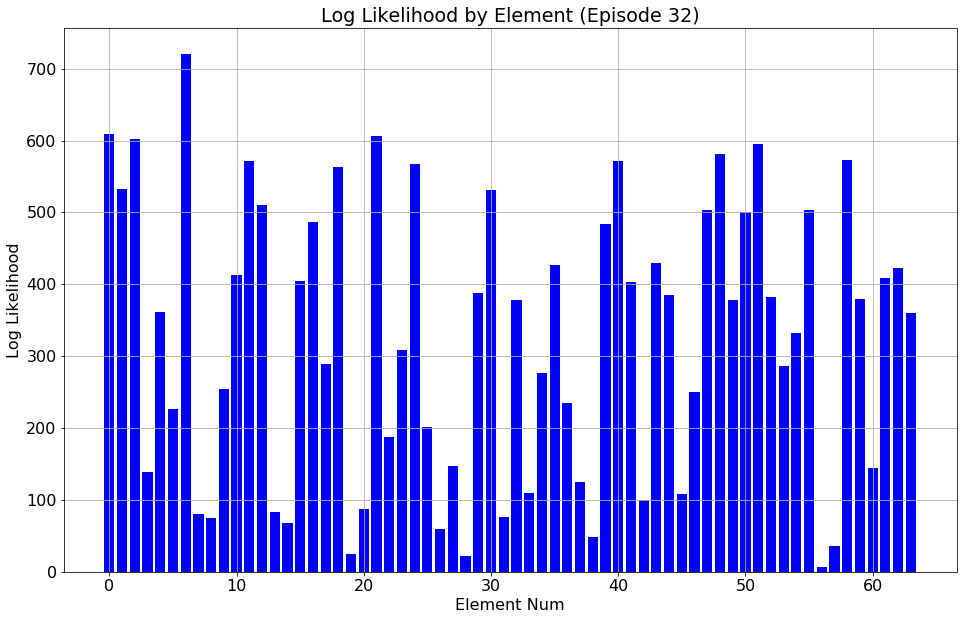

In [37]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [38]:
raise ValueError

ValueError: 

## Train on Perturbed Model: Joint (Elements & Mixture)

In [ ]:
# # Adaptive search parameters
# batches_per_epoch = 100
# epochs_per_episode = 5
# max_bad_episodes = 3
# min_learning_rate = None
# save_at_end = False
# reset_active_weight = True
# verbose = 1

In [39]:
# Train model
model.thaw_all()
model.search_adaptive(
    max_batches=model.current_batch+5000,
    learning_rate=2.0**-12,
    reset_active_weight=True)


Training episode 32: Epoch   86, Batch   8600
effective_learning_rate=2.441e-04, training_time 552 sec.
Train on 6400 samples
Epoch 87/91
6400/6400 [==============================] - 6s 883us/sample - loss: -936.2139
Epoch 88/91
3648/6400 [================>.............] - ETA: 1s - loss: -2544.7456

KeyboardInterrupt: 

In [ ]:
model.report()

In [ ]:
# Train model in joint mode
model.thaw_candidate_elements()
model.search_adaptive(
    max_batches=model.current_batch+5000,
    learning_rate=2.0**-12,
    min_learning_rate=2.0**-24,
    reset_active_weight=False)

In [ ]:
model.report()

In [ ]:
# model.save_state()

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# Bar chart - hits
fig, ax = model.plot_bar('hits', sorted=False)

In [ ]:
# Bar chart - resolution
fig, ax = model.plot_bar('R_deg', sorted=False)

In [ ]:
# Bar chart - sigma_mag
fig, ax = model.plot_bar('sigma_mag', sorted=False)

In [ ]:
# # Save model
# model.save_state()

In [ ]:
# Search 
model.thaw_all()
model.search_adaptive(
    max_batches=model.current_batch+5000, 
    learning_rate=2**-12,
    reset_active_weight=False)

In [ ]:
model.report()

In [ ]:
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# model.save_state()

In [ ]:
# # Unfreeze the score layer
# model.thaw_score()

In [ ]:
# # Lower threshold manually
# thresh_deg_score = 1.0
# model.set_thresh_deg_max(thresh_deg_score)
# model.freeze_score()

In [ ]:
# model.search_adaptive(
#     max_batches=20000, 
#     batches_per_epoch=batches_per_epoch,
#     epochs_per_episode=epochs_per_episode,
#     learning_rate=2.0**-15,
#     reset_active_weight=True,
#     verbose=verbose)

In [ ]:
# model.report()

In [ ]:
# model.save_state()

## Review Results Graphically

In [40]:
model.load()

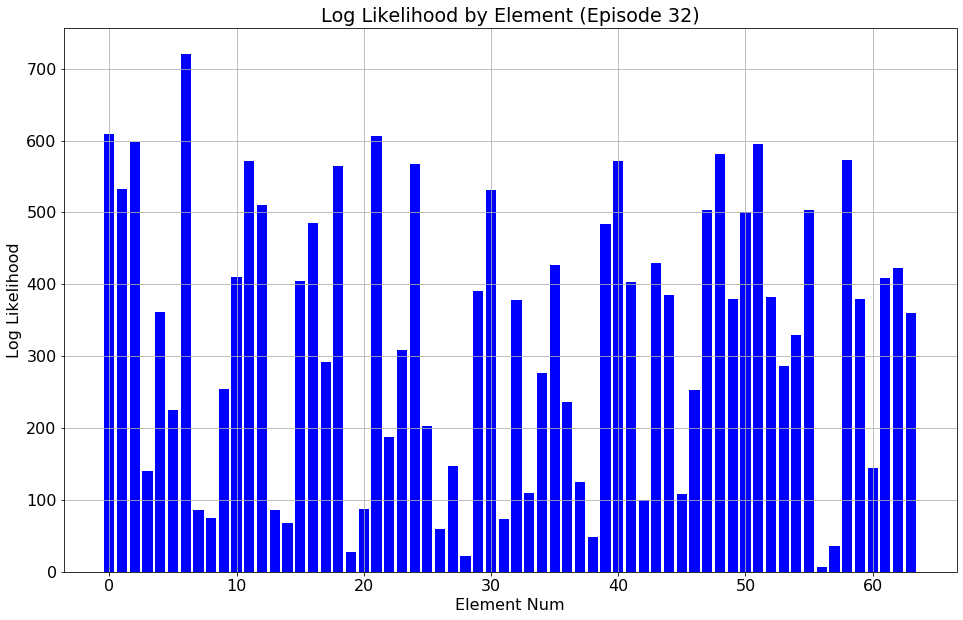

In [41]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

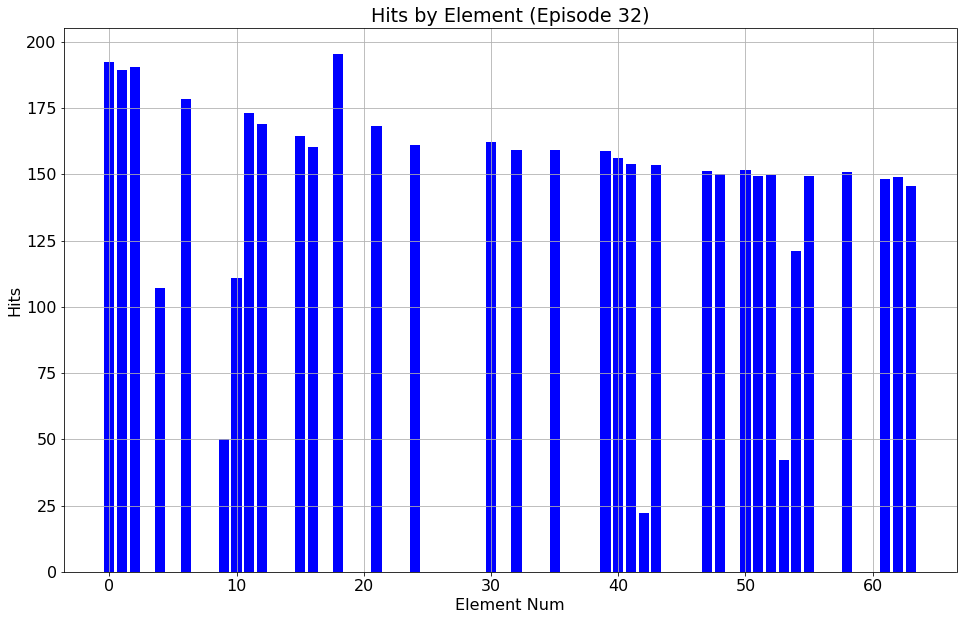

In [42]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

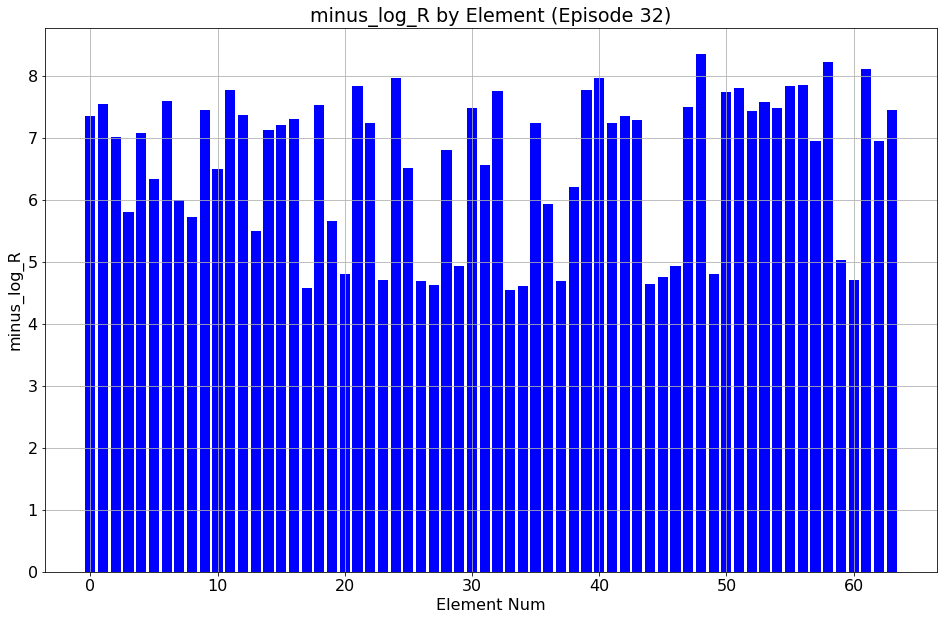

In [43]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('minus_log_R', sorted=False)

In [ ]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [ ]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [44]:
# Find nearest asteroid to fitted elements
elts_fit, elts_near = model.nearest_ast()

In [46]:
# model.save_state()

In [ ]:
# q_norm = elt_q_norm(elts=elts_fit, ast_num=elts_fit.nearest_ast_num)
# elts_fit['nearest_ast_q_norm'] = q_norm

In [ ]:
elt_q_norm(elts=model.elts_fit, ast_num=model.elts_near_ast.nearest_ast_num)

In [47]:
# Review asteroids nearest to the fitted elements
elts_near

,element_id,nearest_ast_num,nearest_ast_name,nearest_ast_dist,a,e,inc,Omega,omega,f,epoch,nearest_ast_q_norm
0,51921,51921,2001 QU90,0.001334,2.669306,0.217361,0.499554,4.699703,2.450796,-1.133491,58600.0,0.018009
1,59244,59244,1999 CG6,0.000114,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0,0.033423
2,15786,15786,1993 RS,0.002329,1.883227,0.047655,0.392360,6.134689,0.804823,-1.246069,58600.0,0.032022
3,3904,183376,2002 XM30,0.005325,2.629361,0.151293,0.251135,4.998281,2.500687,-1.282352,58600.0,1.029664
4,142999,142999,2002 VZ98,0.000089,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0,0.004076
...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,11952,1994 AM3,0.003118,2.219650,0.086091,0.117967,0.042442,2.904823,-3.016580,58600.0,0.285117
60,134815,323805,2005 QT165,0.007714,2.728667,0.140163,0.458260,0.302517,0.496076,-0.584965,58600.0,0.934417
61,27860,27860,1995 BV2,0.000322,2.619406,0.096185,0.200633,5.541400,3.266046,3.948770,58600.0,0.027114
62,85937,85937,1999 DL1,0.001699,2.342291,0.197267,0.439063,5.279693,3.210025,3.947687,58600.0,0.047283


In [48]:
# Review fitted elements including nearest asteroid
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_s,thresh_deg,thresh_sec,log_like,hits,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,2.675046,0.218450,0.499993,4.699408,2.453120,-1.134141,58600.0,218.098709,0.000640,...,0.009888,0.566537,2039.532593,609.789307,192.484192,14.370741,3.920355,51921,0.001334,0.018009
1,59244,2.634402,0.262740,0.464963,5.738107,1.770300,-1.604035,58600.0,189.277298,0.000528,...,0.004279,0.245144,882.517334,532.247925,189.465775,16.223373,3.979937,59244,0.000114,0.033423
2,15786,1.889393,0.049567,0.392994,6.134999,0.799119,-1.238233,58600.0,243.072052,0.000901,...,0.027122,1.554050,5594.581055,598.224670,190.409561,14.719053,4.188690,15786,0.002329,0.032022
3,3904,2.633085,0.112778,0.276166,5.456234,2.206308,-1.354316,58600.0,227.127686,0.002998,...,0.034905,2.000000,7199.998535,140.794662,0.000000,16.939259,3.575644,183376,0.005325,1.029664
4,142999,2.619658,0.191178,0.513962,0.237874,0.944763,-1.298294,58600.0,205.016174,0.000838,...,0.011942,0.684220,2463.191650,361.568115,107.172722,15.660192,3.983000,142999,0.000089,0.004076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.226659,0.062010,0.116723,0.035377,2.878006,-3.014315,58600.0,1023.999939,0.006515,...,0.034905,2.000000,7199.998535,379.601379,0.000000,14.368334,4.261757,11952,0.003118,0.285117
60,134815,2.724872,0.194788,0.510490,0.258896,0.659054,-0.985220,58600.0,454.349121,0.009013,...,0.034905,2.000000,7199.998535,144.314880,0.000000,15.891478,3.665882,323805,0.007714,0.934417
61,27860,2.618529,0.093890,0.200662,5.541882,3.264583,3.948677,58600.0,151.899857,0.000302,...,0.003523,0.201834,726.601929,408.585968,148.230881,15.084631,3.990959,27860,0.000322,0.027114
62,85937,2.336179,0.193380,0.438922,5.280168,3.210401,3.943785,58600.0,173.076828,0.000958,...,0.011126,0.637500,2294.999756,423.030579,149.177841,16.095934,3.537576,85937,0.001699,0.047283


In [ ]:
# Filter for only the good ones
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 120)
elts_fit[mask]

In [ ]:
# Filter for incomplete convergence
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
model.elts_near_ast

In [ ]:
use_near_ast_dist = True
is_log = False
plot_type = 'cart'
self = model

# If elts_true wasn't specified, it defaults to nearest asteroid elements
elts_true = self.elts_near_ast

# Calculate distance error with selected method: live or from near_ast
if use_near_ast_dist:
    q_err = self.elts_near_ast.nearest_ast_dist
    calc_method = '20 Years of Monthly Dates'
else:
    hist_err, q_err = self.calc_error(elts_true)
    calc_method = 'Observation Dates'

# Compute the q_norm error
q_norm_err = elt_q_norm(elts=self.elts_fit, ast_num=model.elts_near_ast.nearest_ast_num)

# Choose between Cartesian distance and q_norm
err_tbl = {
    'cart': q_err,
    'cov': q_norm_err,
}
err = err_tbl[plot_type]

# Get element numbers and mean error over the whole batch
element_num = np.arange(self.batch_size, dtype=np.int32)
mean_err = np.exp(np.mean(np.log(err+2**-40))) if is_log else np.mean(err)

# Type of error
is_q_norm: bool = (plot_type == 'cov')
# error_type = 'Covariance' if is_q_norm else 'Cartesian'
error_tag = 'Covariance Error' if is_q_norm else 'Mean Position Error in AU'

# Caption for y-axis
ylabel_prefix = 'Inverse ' if is_log else ''
ylabel_suffix = ' (log scaled)' if is_log else ''
ylabel = f'{ylabel_prefix}{error_tag}{ylabel_suffix}'

# Plot selected error
fig, ax = plt.subplots()
ax.set_title(f'{error_tag} vs. Elements on {calc_method}')
ax.set_xlabel('Element')
ax.set_ylabel(ylabel)
if is_log:
    ax.bar(x=element_num, height=1.0/err, label='elt', color='blue')
    ax.axhline(y=1.0/mean_err, label='mean', color='red')
    ax.set_yscale('log', basey=2)
else:
    ax.bar(x=element_num, height=err, label='elt', color='blue')
    ax.axhline(y=mean_err, label='mean', color='red')
ax.grid()
ax.legend()
# fig.savefig('../figs/training/q_error.png', bbox_inches='tight')
plt.show()

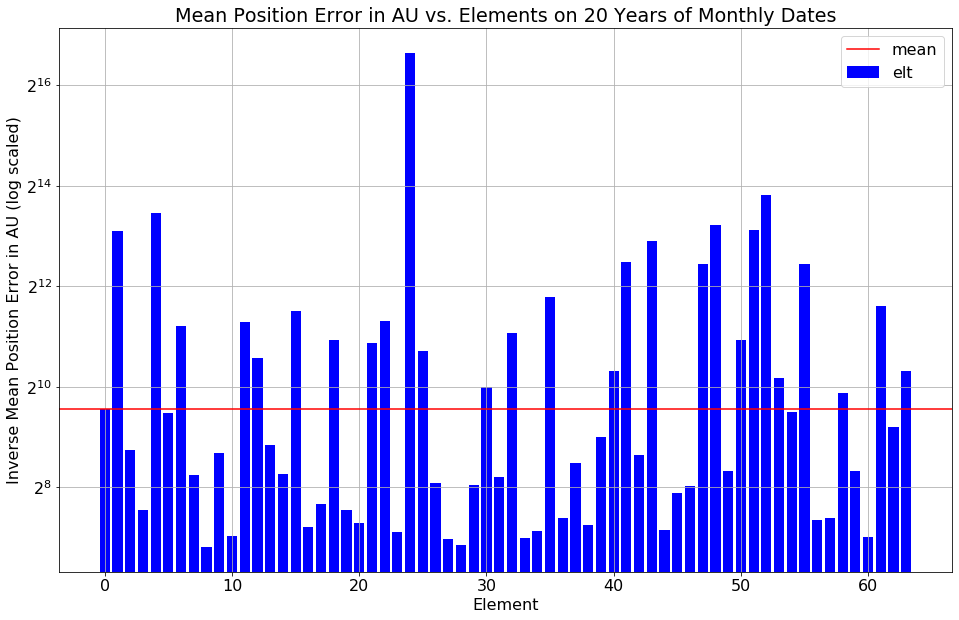

In [50]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

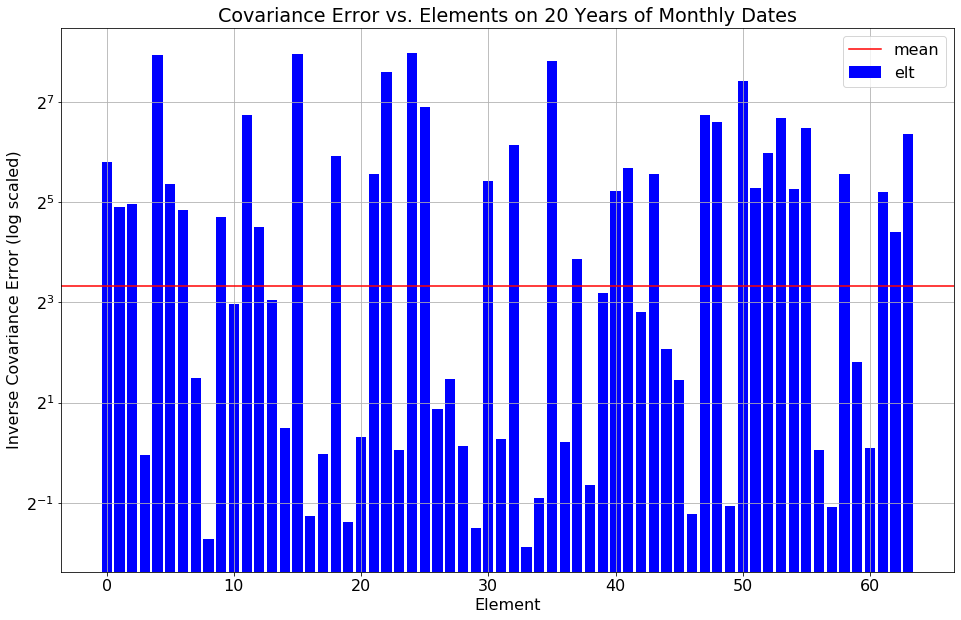

In [51]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

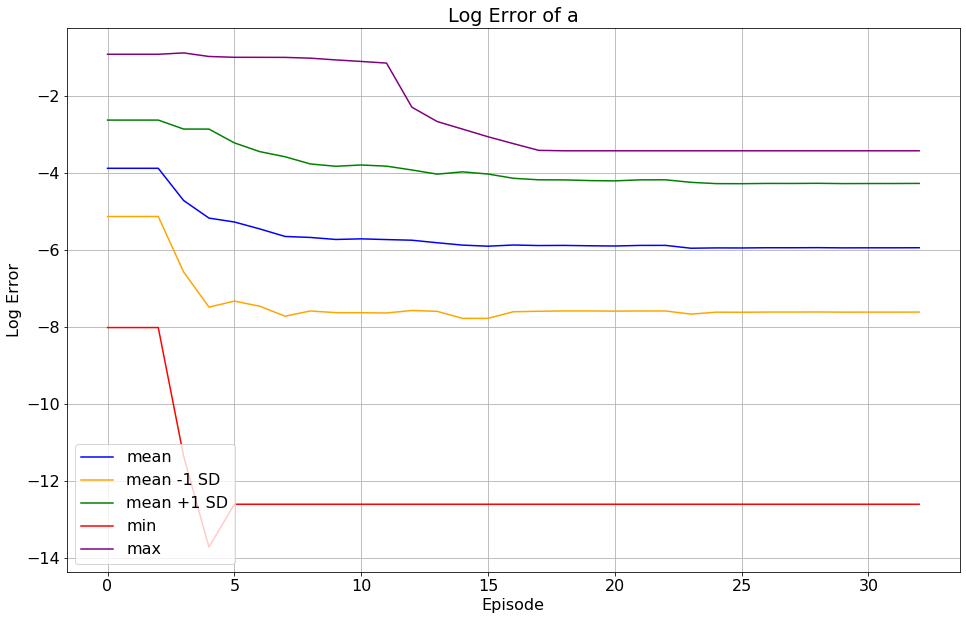

In [52]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='a', is_log=True, elt_num=None)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='e', is_log=True, elt_num=None)